### <center> Прогнозирование оценки отеля на Booking.com

Краткое описание проекта  
Мы будем анализировать данные, предоставленные компанией Booking. Проблема: существуют нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить. Задача: создать модель, которая на основе входных данных наиболее точно прогнозирует рейтинг отеля.

In [1]:
# импортируем необходимые библиотеки

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import category_encoders as ce #кодирование признаков
import re # для использования регулярных выражений

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# для вычисления расстояния
from geopy.distance import geodesic as GD

# для нормализации
from sklearn import preprocessing

# для отбора признаков
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

# загружаем библиотеку для разделения датасета:
from sklearn.model_selection import train_test_split

# импортируем необходимые библиотеки для создания модели
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
#  Для определения характера распределения воспользуемся методом Шапиро
from scipy.stats import shapiro
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [187]:
# фиксируем RANDOM_SEED для воспроизводимости экспертиментов
RANDOM_SEED = 42

In [188]:
# также зафиксируем версию пакетов для вопроизводимости кода
!pip freeze > requirements.txt

In [ ]:
# подгрузим данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [189]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [ ]:
df_train.head(2)

In [ ]:
df_test.info()

In [ ]:
sample_submission.info()

In [ ]:
sample_submission.head(2)

In [190]:
hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,384355.000000,384355.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.443522,2.823402
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.466936,4.579043
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214662,-0.143649
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,-0.000250
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.429233


In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем df_train и df_test в один датасет
df_train['sample'] = 1 # помечаем где у нас обучающая выборка
df_test['sample'] = 0 # помечаем где у нас тестовая выборка
# в тесте у нас нет значения reviewer_score, 
# мы его должны предсказать, поэтому пока просто заполняем нулями
df_test['reviewer_score'] = 0

data = pd.concat([df_train, df_test]).reset_index(drop=True) # объединяем

hotel_address - адрес отеля

additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки

review_date - дата, когда рецензент разместил соответствующий отзыв

average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год

hotel_name - название отеля

reviewer_nationality - национальность рецензента

negative_review - отрицательный отзыв, который рецензент дал отелю

review_total_negative_word_counts - общее количество слов в отрицательном отзыв

positive_review - положительный отзыв, который рецензент дал отелю

review_total_positive_word_counts - общее количество слов в положительном отзыве

reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта

total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом

total_number_of_reviews - общее количество действительных отзывов об отеле

tags - теги, которые рецензент дал отелю

days_since_review - продолжительность между датой проверки и датой очистки

lat - широта отеля

lng - долгота отеля

#### Исследование данных

In [191]:
hotels.describe(include='object')

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,386803,386803,386803,386803,386803,386803,386803,386803
unique,1493,731,1492,225,248828,311737,47135,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,3587,1911,3587,184033,95907,26885,3853,1911


Категориальные признаки имеют много уникальных значений, перед кодированием их необходимо очистить и сгруппировать.
На этапе подготовки данных постараемся извлечь из них как можно больше полезной информации.
Из признака "hotel_address" можно извлечь страну и город расположения отеля.
Из "review_date" выделим месяц оставленного отзыва, чтобы оценить, как на оценку влияет сезонность.
Для категоризации остальных признаков необходимо более подробно рассмотреть данные в разрезе.

In [ ]:
# оценим распределение числовых признаков
data.drop(columns=['reviewer_score', 'sample'], axis=1).hist(figsize=(15, 10))

array([[<AxesSubplot: title={'center': 'additional_number_of_scoring'}>,
        <AxesSubplot: title={'center': 'average_score'}>,
        <AxesSubplot: title={'center': 'review_total_negative_word_counts'}>],
       [<AxesSubplot: title={'center': 'total_number_of_reviews'}>,
        <AxesSubplot: title={'center': 'review_total_positive_word_counts'}>,
        <AxesSubplot: title={'center': 'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot: title={'center': 'reviewer_score'}>,
        <AxesSubplot: title={'center': 'lat'}>,
        <AxesSubplot: title={'center': 'lng'}>]], dtype=object)

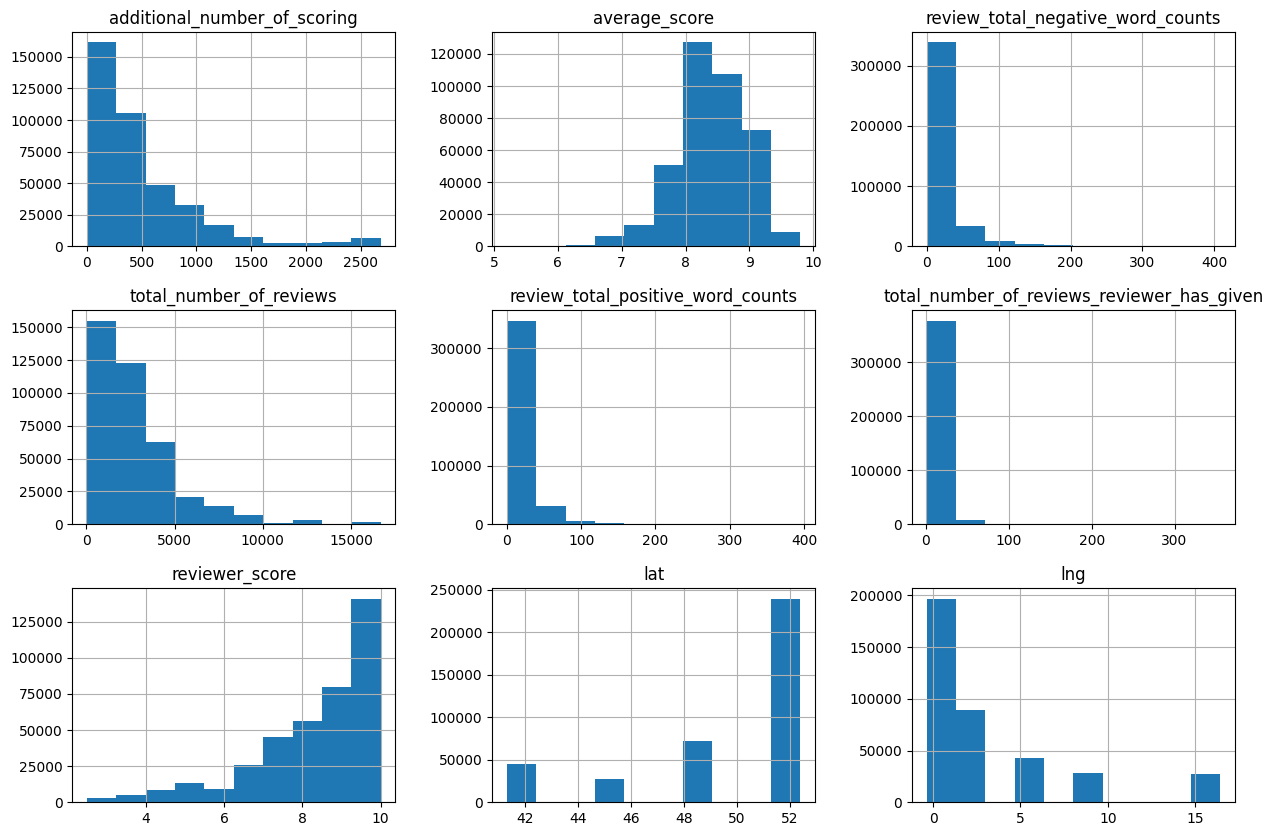

In [192]:
# оценим распределение числовых признаков
hotels.hist(figsize=(15, 10))

Практически все непрерывные признаки имеют распределение, отличное от нормального, возможно, за исключением "average_score", по нему необходимо будет провести тест на нормальность. Остальные признаки необходимо проанализировать на наличие выбросов и провести нормализацию.

In [ ]:
# Построим тепловую карту матрицы корреляций признаков
# Поскольку непрерывные признаки имеют распределение, отличное от нормального, 
# то воспользуемся методом коррелиции Спирмена
corr = data.drop('sample', axis=1).corr(method='spearman')
matrix = np.triu(corr)
plt.figure(figsize = (15,10))
sns.heatmap(corr, annot=True, annot_kws={"size":14}, fmt='.2g', 
            mask=matrix, cmap='Oranges')

Признаки "total_number_of_reviews" и "additional_number_of_scoring" имеют сильную связь, в дальнейшем мы преобразуем их, чтобы это не влияло негативно на модель.

### Подготовка данных 
##### Преобразование категориальных признаков

Для начала разделим признаки по типу, перечислим их:

In [194]:
# категориальные признаки
cat_cols = [s for s in hotels.columns if hotels[s].dtypes == 'object']
# непрерывные признаки
num_cols = [s for s in hotels.columns if hotels[s].dtypes != 'object']
display('Категориальные признаки:', cat_cols)
display('Непрерывные признаки:', num_cols)


'Категориальные признаки:'

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review']

'Непрерывные признаки:'

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'lat',
 'lng']

*1. Преобразование признака "hotel_address"*

In [195]:
hotels.hotel_address.value_counts()

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              3587
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     3206
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     3095
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    2688
7 Pepys Street City of London London EC3N 4AF United Kingdom                      2379
                                                                                  ... 
Via Palmanova 153 20132 Milan Italy                                                  7
40 Rue Rene Boulanger 10th arr 75010 Paris France                                    7
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                              6
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              6
13 Rue Fran ois Ory 92120 Paris France                                               5
Name: hotel_address, Length: 1493, dtype: i

Как видно, последний элемент в каждой строке обозначает страну, а предпоследний - город.
Однако отметим, что United Kingdom состоит из двух слов и между городом и страной есть ещё элементы, учтём это при парсинге данных из текущего признака.

In [196]:
# Создадим функцию для извлечения страны из признака
def get_country(address):
    country = address.split()[-1]
    if country == 'Kingdom':
        return 'United Kingdom'
    else:
        return country

In [197]:
# Создадим копию датасета перед преобразованием признаков
data = hotels.copy()

In [198]:
data['country'] = data.hotel_address.apply(get_country)
data.country.value_counts()

United Kingdom    196774
Spain              45132
France             44830
Netherlands        43006
Austria            29178
Italy              27883
Name: country, dtype: int64

In [199]:
# Создадим функцию для извлечения города из признака
def get_city(address):
    if address.split()[-1] == 'Kingdom':
        return address.split()[-5]
    else:
        return address.split()[-2]

In [200]:
data['city'] = data.hotel_address.apply(get_city)
data.city.value_counts()

London       196774
Barcelona     45132
Paris         44830
Amsterdam     43006
Vienna        29178
Milan         27883
Name: city, dtype: int64

*2. Преобразование признака "review_date"*

In [201]:
# Преобразуем признак в формат даты, чтобы извлечь месяц, когда был оставлен отзыв
data['season'] = pd.to_datetime(data.review_date).dt.month
# напишем функцию для определения сезона
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    return 'Autumn'

In [202]:
data.season = data.season.apply(get_season)
data.season.value_counts()

*3. Преобразование признака "hotel_name"*

In [204]:
data.hotel_name.value_counts().iloc[:10]

Britannia International Hotel Canary Wharf           3587
Strand Palace Hotel                                  3206
Park Plaza Westminster Bridge London                 3095
Copthorne Tara Hotel London Kensington               2688
DoubleTree by Hilton Hotel London Tower of London    2379
Grand Royale London Hyde Park                        2218
Holiday Inn London Kensington                        2097
Hilton London Metropole                              1982
Intercontinental London The O2                       1939
Millennium Gloucester Hotel London                   1889
Name: hotel_name, dtype: int64

In [205]:
# Составляем список c наименованиями сетей отелей
hotel_chains = ['Ibis', 'Best Western', 'Holiday Inn', 'Mercure', 'Premier Inn',
                    'Novotel', 'Hilton', 'NH', 'Travelodge', 'Four Seasons', 'Hyatt',
                    'InterContinental', 'Kempinski', 'Lotte', 'Marriott', 'Ritz',
                    'Millennium', 'Copthorne', 'Radisson', 'Wyndham', 'Accor', 'Whitbread',
                    'Melia', 'Louvre', 'TUI', 'Carlson', 'Motel One'
                    ]
# напишем функцию, которая будет проверять принадлежность отеля к сети
def is_chain(hotel):
    for h in hotel_chains:
        if h.lower() in hotel.lower():
            return 1
    return 0

In [206]:
data['is_chain'] = data.hotel_name.apply(is_chain)
data.is_chain.value_counts()

*4. Преобразование признака "reviewer_nationality"*

In [208]:
data.reviewer_nationality.value_counts().iloc[:15]

 United Kingdom               184033
 United States of America      26541
 Australia                     16239
 Ireland                       11126
 United Arab Emirates           7617
 Saudi Arabia                   6722
 Netherlands                    6608
 Switzerland                    6498
 Canada                         5984
 Germany                        5956
 France                         5543
 Israel                         4918
 Italy                          4562
 Belgium                        4529
 Turkey                         4105
Name: reviewer_nationality, dtype: int64

In [209]:
# Сократим количество национальностей, выделим топ-3 национальности, остальных объединим в группу "Other"
most_freq_nat = data.reviewer_nationality.value_counts().nlargest(3)
data.reviewer_nationality = data.reviewer_nationality.apply(
    lambda x: x if x in most_freq_nat else 'Other') 

In [210]:
# Воспользуемся методом np.where, чтобы создать признак, 
# в котором страна отеля совпадает со страной пользователя
# но перед этим удалим лишние пробелы в национальности пользователей
data.reviewer_nationality = data.reviewer_nationality.apply(lambda x: x.strip())
data['is_citizen'] = np.where(data.country == data.reviewer_nationality, 1, 0)
data.is_citizen.value_counts()

*5. Преобразование признака "negative_review"*

In [212]:
data.negative_review.value_counts().iloc[:30]

No Negative            95907
 Nothing               10737
 Nothing                3154
 nothing                1660
 N A                     802
 None                    737
                         606
 N a                     384
 Breakfast               296
 Small room              283
 Location                281
 All good                251
 Everything              251
 Nothing really          240
 none                    223
 nothing                 219
 No complaints           201
 Nil                     197
 Nothing really          195
 Price                   192
 n a                     176
 Nothing to dislike      159
 Nothing at all          154
 Nothing at all          139
 Small rooms             135
 None                    134
 No complaints           129
 All good                116
 NA                      109
 Expensive               105
Name: negative_review, dtype: int64

Как мы видим по распределению, многие отзывы на самом деле не являются негативными, необходимо очистить от них наш признак. Перед очисткой приведём их к единому виду - удалим лишние пробелы и уберём верхний регистр.

In [213]:
data.negative_review = data.negative_review.apply(lambda x: x.strip().lower())

In [214]:
no_negative = [
    'no negative', 'nothing','n a', 'na', 'none', ' ', 'nothing really', 
    'all good', 'no complaints', 'nothing at all', 'nothing at all', 
    'nil', 'everything was perfect', 'absolutely nothing','everything was great',
    'nothing to complain about', 'no', 'nothing not to like' 
    ]
data['non_negative'] = data.negative_review.apply(
    lambda x: 0 if x in no_negative else 1)
data.non_negative.value_counts()

6. *Преобразование признака "positive_review"*

In [217]:
data.positive_review.value_counts().iloc[:30]

No Positive            26885
 Location               6833
 Everything             1697
 location               1251
 Nothing                 931
 The location            830
 Great location          809
 Good location           690
 Location                663
 Breakfast               455
 Everything              449
 Friendly staff          385
 Staff                   347
 Excellent location      296
 Great location          280
 Location and staff      256
 everything              233
 Good location           214
 Nothing                 170
 nothing                 159
 Comfy bed               158
 The location            152
 good location           151
 The staff               151
 the location            141
 Location was good       140
 Location was great      137
 Location staff          136
 Good breakfast          130
                         128
Name: positive_review, dtype: int64

По позитивным отзывам наблюдается схожая с предыдущим пунктом ситуация.
Проведём те же манипуляции и очистим признак от ложноположительных отзывов.

In [218]:
data.positive_review = data.positive_review.apply(lambda x: x.strip().lower())

In [219]:
no_positive = [
    'no positive', 'nothing'
    ]
data['non_positive'] = data.positive_review.apply(
    lambda x: 0 if x in no_positive else 1)
data.non_positive.value_counts()

*7. Преобразование признака "tags"*

In [221]:
data.tags.value_counts()

[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                                              3853
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                                     3673
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                                     3274
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                                       2964
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']                                                             2454
                                                                                                                                                      

Признак "tags" содержит обширный массив данных, для категоризации проведём детальный анализ и выведем наиболее часто встречающиеся показатели

In [222]:
# удалим лишние символы в начале и в конце каждой строки 
# с помощью среза [2:-2] и метода strip(). Также удалим пробелы в каждом элементе списка
tags = data.tags.apply(lambda x: x[2:-2].strip().split(' \', \' '))
# каждый элемент списка в признаке tags выведем в отдельную строку
tags = tags.explode('tags')

In [223]:
tags.value_counts().iloc[:20]

Leisure trip                      313593
Submitted from a mobile device    230778
Couple                            189212
Stayed 1 night                    145373
Stayed 2 nights                   100263
Solo traveler                      81235
Stayed 3 nights                    72000
Business trip                      61989
Group                              49088
Family with young children         45836
Stayed 4 nights                    35748
Double Room                        26386
Standard Double Room               24151
Superior Double Room               23550
Family with older children         19802
Deluxe Double Room                 18623
Double or Twin Room                16824
Stayed 5 nights                    15611
Standard Double or Twin Room       13062
Classic Double Room                12716
Name: tags, dtype: int64

Наиболее популярные теги: 
* Цель поездки ("Leisure"|"Business")
* Способ подтверждения ("Submitted from a mobile device")
* Количество людей ("Couple"|"Solo traveler"|"Group"|"With children")
* Длительность проживания ("Stayed x days")

Выделим их в отдельные признаки

 *7.1 Цель поездки*

In [224]:
# ~ 10 000 тыс. рецензентов не указали цель поездки
trip_reg = 'Leisure|Business' # используем регулярное выражение
data['trip'] = data['tags'].str.findall(trip_reg).str.get(0)
# дополним недостающие данные модальным значением
data.trip = data.trip.fillna(data.trip.mode()[0]) 
data.trip.value_counts()

*7.2 Способ подтверждения*

In [226]:
data['confirmation'] = data.tags.apply(
    lambda x: 1 if 'Submitted from a mobile device' in x else 0)
data.confirmation.value_counts()

*7.3 Длительность проживания*

In [228]:
# Для извлечения признака из списка используем регулярные выражения
stayed_reg = 'Stayed\s([\d]*)' # используем регулярное выражение
data['days_stayed'] = data.tags.str.findall(stayed_reg).str.get(0)
# дополним недостающие данные модальным значением
data.days_stayed = data.days_stayed.fillna(data.days_stayed.mode()[0])
# преобразуем тип данных в числовой
data.days_stayed = data.days_stayed.astype('int64')
data.days_stayed.value_counts()

*7.4 Количество людей*

In [230]:
count_reg = 'Solo|Couple|Group|Family with older children|Family with young children'
data['group_type'] = data.tags.str.findall(count_reg).str.get(0)
data.group_type = data.group_type.fillna(data.group_type.mode()[0])

*8. Преобразование признака "days_since_review"*

In [232]:
data.days_since_review.value_counts()

1 days     1911
322 day    1738
120 day    1702
338 day    1462
534 day    1451
           ... 
122 day     154
243 day     154
615 day     146
124 day     127
123 day     111
Name: days_since_review, Length: 731, dtype: int64

In [233]:
days_reg = '\d{1,3}'
data.days_since_review = data.days_since_review.str.findall(days_reg).str.get(0)
data.days_since_review = data.days_since_review.astype('int64')

Сделаем предположение, что отзывы, оставленные менее года назад более актуальны, выведем их в отдельный признак.

In [234]:
data['left_within_year'] = data.days_since_review.apply(
    lambda x: 1 if x < 365 else 0)
data.left_within_year.value_counts()

1    200724
0    186079
Name: left_within_year, dtype: int64

Вернёмся к признакам "lat" и  "lng", в которых у нас были обнаружены пропуски.
Поскольку по своей сути эти признаки не являются числовыми в чистом виде, а обозначают координаты отеля, то к их заполнению нужно отнестись очень осторожно, чтобы не исказить данные. Рассмотрим подробнее струкуру данных с пропусками.

In [235]:
mask = data.lat.isnull()
print('Количество отелей без координат: ', data[mask]['hotel_name'].nunique())
data[mask]['city'].value_counts()

Количество отелей без координат:  17


Vienna       1990
Paris         299
Barcelona     159
Name: city, dtype: int64

Данные пропущены по 3 городам всего в 17 отелях, можем позволить себе восполнить пропуски медианными значениями долготы и широты по каждому городу.

In [236]:
Par_mask = data.city == 'Paris'
Barc_mask = data.city == 'Barcelona'
Vien_mask = data.city == 'Vienna'
# выведем медианные значения долготы и широты по Парижу, Барселоне и Вене
lat_Par = data[Par_mask]['lat'].median()
lng_Par = data[Par_mask]['lng'].median()
lat_Barc = data[Barc_mask]['lat'].median()
lng_Barc = data[Barc_mask]['lng'].median()
lat_Vien = data[Vien_mask]['lat'].median()
lng_Vien = data[Vien_mask]['lng'].median()
# Значения, которые будем вставлять
Par_values = {'lat' : lat_Par, 'lng' : lng_Par}
Barc_values = {'lat' : lat_Barc, 'lng' : lng_Barc}
Vien_values = {'lat' : lat_Vien, 'lng' : lng_Vien}
#  Заполняем пропущенные значения
data[Par_mask] = data[Par_mask].fillna(Par_values)
data[Barc_mask] = data[Barc_mask].fillna(Barc_values)
data[Vien_mask] = data[Vien_mask].fillna(Vien_values)

In [237]:
# Убедимся, что пропущенных значений больше не осталось
data.isnull().mean()

hotel_address                                 0.0
additional_number_of_scoring                  0.0
review_date                                   0.0
average_score                                 0.0
hotel_name                                    0.0
reviewer_nationality                          0.0
negative_review                               0.0
review_total_negative_word_counts             0.0
total_number_of_reviews                       0.0
positive_review                               0.0
review_total_positive_word_counts             0.0
total_number_of_reviews_reviewer_has_given    0.0
reviewer_score                                0.0
tags                                          0.0
days_since_review                             0.0
lat                                           0.0
lng                                           0.0
country                                       0.0
city                                          0.0
season                                        0.0


Сами по себе координаты отеля не представляют ценности для модели, попробуем извлесь из них что нибудь полезное, например, удалённость от центра города. Для этого воспользуемся библиотекой geopy.

In [238]:
# Создадим DataFrame с координатами центров городов, где находятся отели
centers = pd.DataFrame(data=[
    ['London', 51.51, -0.13], 
    ['Paris', 48.85, 2.35],
    ['Vienna', 48.21, 16.37],
    ['Amsterdam', 52.37, 4.89],
    ['Barcelona', 41.39, 2.16], 
    ['Milan', 45.46, 9.19]],
    columns = ['city', 'center_lat', 'center_lng']  
    )   
# Выделим отдельный датафрейм с координатами отелей и 
# объединим его с датафреймом координат центров
hotels_short = data[['hotel_address', 'city', 'lat', 'lng']].drop_duplicates()
hotels_short = hotels_short.merge(centers, on='city', how='left')
# напишем функцию, которая будет высчитывать расстояние до центра города
def get_distance(center_lat, center_lng, lat, lng):
   return round(GD([center_lat, center_lng], [lat, lng]).km, 2)
# Применим функцию к новому датафрейму
hotels_short['center_distance'] = hotels_short.apply(
    lambda x: get_distance(x['center_lng'], 
    x['center_lat'], x['lng'], x['lat']), axis=1)
# перед объединением с основным датасетом удалим лишние признаки, 
# чтобы у нас остались только название отеля и расстояние до центра
hotels_short = hotels_short.drop(columns = [
    'city', 'center_lat', 'center_lng', 'lat', 'lng'], axis=1)
# Осталось объединить полученный признак с основным датасетом
data = data.merge(hotels_short, on='hotel_address', how='left')


In [239]:
# Создадим отдельный признак с отелями в центре города
data['is_center'] = data.center_distance.apply(lambda x: 1 if x <= 1.5 else 0)
data.is_center.value_counts()

Оценим, насколько расположение в центре коррелирует с положительным отзывом о локации отеля.

In [242]:
# Выведем количество положительных отзывов о локации отеля

display(data.positive_review.str.contains('location').value_counts().loc[True])
# Посмотрим, сколько отелей с положительными отзывами о локации расположены в центре
data[data.positive_review.str.contains('location')]['is_center'].value_counts()

False    244759
True     142044
Name: positive_review, dtype: int64

0    98905
1    43139
Name: is_center, dtype: int64

43% положительных отзывов связаны с отелями, которые расположены в центре. Добавим признак "good_location".

In [301]:
# Выведем топ-10 отелей, получивших наибольшее количество
# положительных отзывов о расположении
data.groupby('hotel_name')['positive_review'].count().sort_values(
    ascending = False).iloc[:10]

hotel_name
Britannia International Hotel Canary Wharf           3587
Strand Palace Hotel                                  3206
Park Plaza Westminster Bridge London                 3095
Copthorne Tara Hotel London Kensington               2688
DoubleTree by Hilton Hotel London Tower of London    2379
Grand Royale London Hyde Park                        2218
Holiday Inn London Kensington                        2097
Hilton London Metropole                              1982
Intercontinental London The O2                       1939
Millennium Gloucester Hotel London                   1889
Name: positive_review, dtype: int64

### Подготовка данных
##### Преобразование непрерывных признаков

*1. Преобразование признаков "review_total_negative_word_counts" и "review_total_positive_word_counts"*

При анализе отзывов мы выяснили, что они содержали много ложноположительных и ложноотрицательных отзывов, это, в свою очередь, исказило признаки с количеством слов в отрицательных и положительных отзывах. Давайте исправим это.

In [244]:
# обнулим количество слов в негативном отзыве в тех строках, где их на самом деле нет
mask = (data.non_negative == 0)
data.loc[mask, 'review_total_negative_word_counts'] = data.loc[
    mask, 'review_total_negative_word_counts'].apply(lambda x: 0 if x > 0 else x)
# Повторим то же самое для положительных отзывов
mask = (data.non_positive == 0)
data.loc[mask, 'review_total_positive_word_counts'] = data.loc[
    mask, 'review_total_positive_word_counts'].apply(lambda x: 0 if x > 0 else x)

In [245]:
data[['additional_number_of_scoring', 'total_number_of_reviews']]

,additional_number_of_scoring,total_number_of_reviews
0,581,1994
1,299,1361
2,32,406
3,34,607
4,914,7586
...,...,...
386798,107,617
386799,272,3224
386800,457,2751
386801,365,1567


Когда мы строили матрицу корреляций непрерывных признаков, то отметили, что "additional_number_of_scoring" имеет сильную связь с "total_number_of_reviews".
Это связано с тем, что первый признак по сути содержится во втором, поскольку общее количество отзывов включает в себя и оценки, оставленные без отзывов. Избавимся от этого признака и заменим его на долю оценок, оставленных без отзывов.

In [246]:
data['non_review_ratio'] = round(data.additional_number_of_scoring / 
    data.total_number_of_reviews, 2)

Построим несколько столбчатых диаграмм, чтобы посмотреть на то, как распределены оставшиеся нечисловые признаки, и как они соотносятся с целевым показателем.

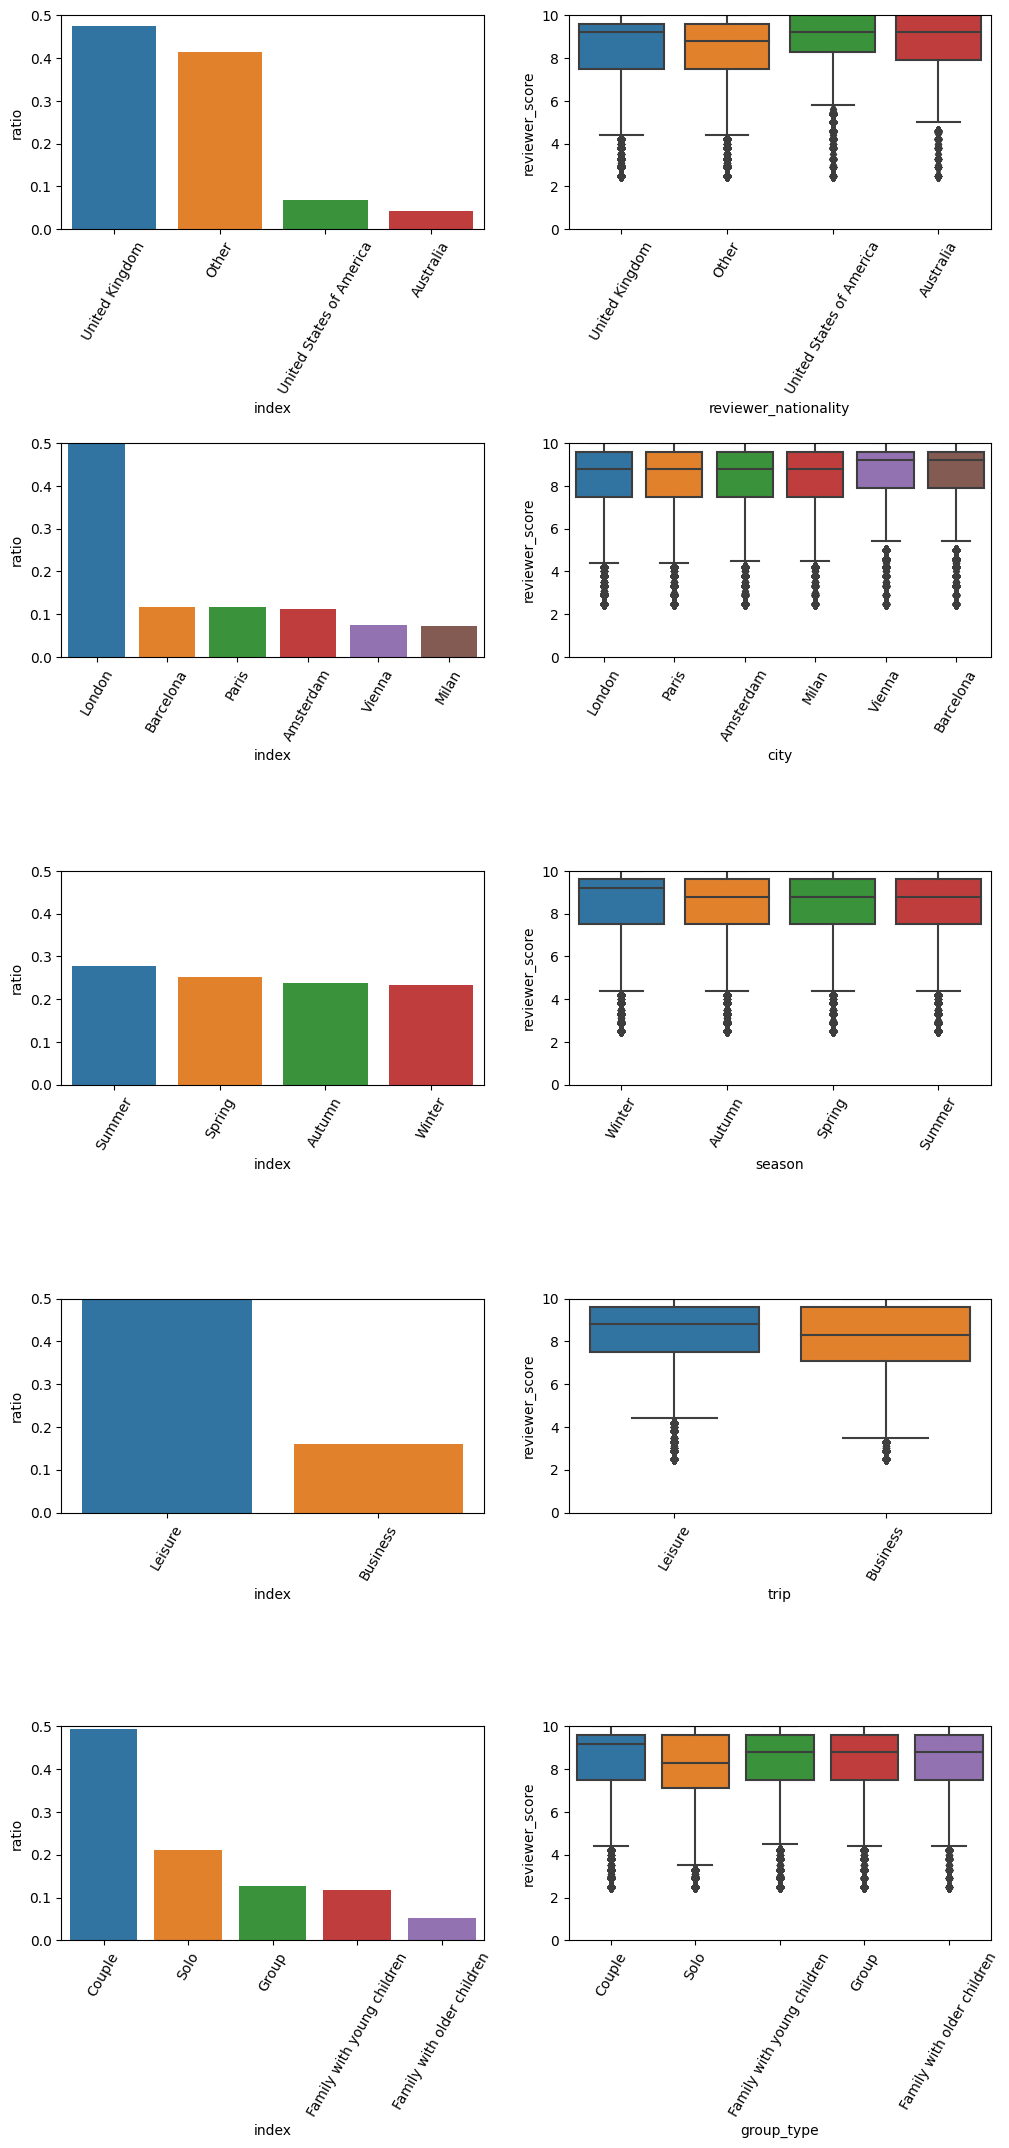

In [275]:
# Создадим список интересующих нас категориальных признаков
cat_cols = [
 'reviewer_nationality',
 'city',
 'season',
 'trip',
 'group_type']
n = len(cat_cols)

fig, axes = plt.subplots(n, 2, figsize=(12, 25))
# Создадим цикл для построения графиков каждого признака
for i, feature in enumerate(cat_cols):
    cat_count = data[feature].value_counts(normalize=True).sort_values(
                ascending=False).rename('ratio').reset_index()
    ratio_barplot = sns.barplot(
        data=cat_count, 
        x='index', 
        y='ratio', 
        ax=axes[i][0]
        )
    ratio_barplot.xaxis.set_tick_params(rotation=60)
    ratio_barplot.set(ylim =(0, 0.5))

    main_boxplot = sns.boxplot(
        data=data,
        x=feature,
        y='reviewer_score',
        ax = axes[i][1]
        )
    main_boxplot.xaxis.set_tick_params(rotation=60)
    main_boxplot.set(ylim =(0, 10))
fig.subplots_adjust(hspace=1.0)


Практически по всем признакам наблюдается высокий разброс итогового рейтинга, при этом значения в перцентилях по признаку Group_type категорий "Family with young children", "Group" и "Family with older children" практически не меняется. Во второй итерации можно объединить вышеназванные категории и удалить неинформативные признаки, а также провести очистку данных от выбросов.

In [ ]:
# data.group_type = data.group_type.apply(lambda x: 'Group' if 'children' in x else x)

*upd: группировка категорий по признаку group_type немного ухудшила метрику модели, откажемся от этого преобразования*

То же самое проделаем с непрерывными признаками

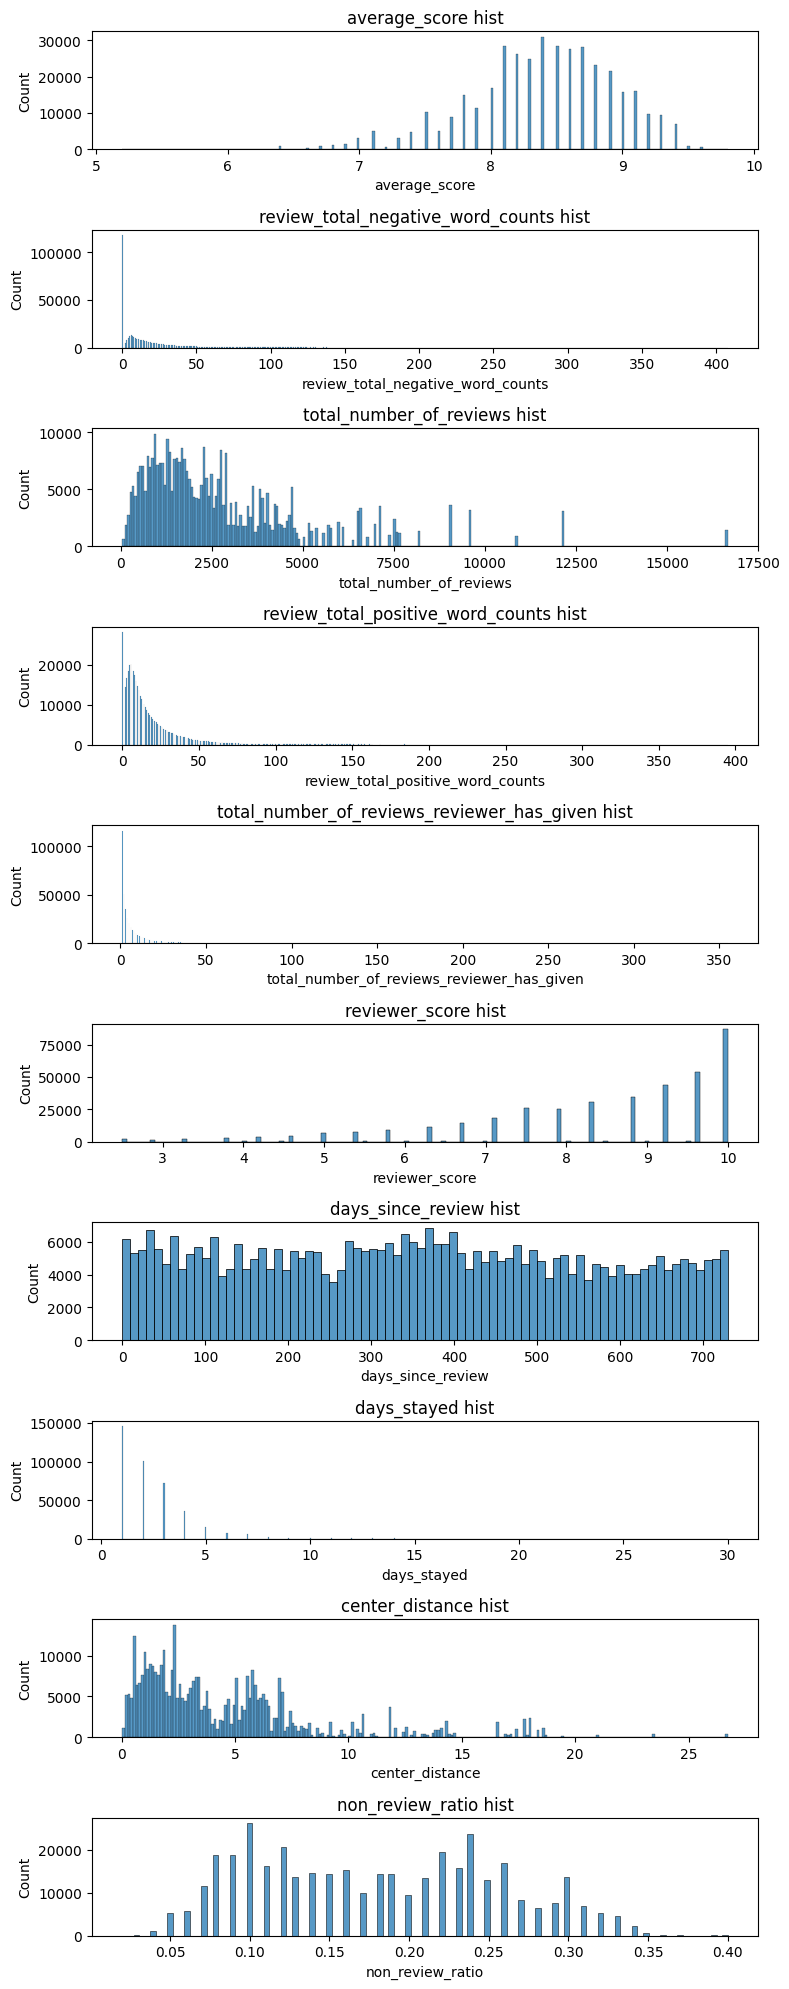

In [279]:
# Создадим список интересующих нас непрерывных признаков
num_cols = [
    'average_score', 'review_total_negative_word_counts', 
    'total_number_of_reviews', 'review_total_positive_word_counts', 
    'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'days_since_review', 
    'days_stayed', 'center_distance', 'non_review_ratio']
n = len(num_cols)

fig, axes = plt.subplots(n, figsize=(8, 20))
# Создадим цикл для построения графиков каждого признака
for i, feature in enumerate(num_cols):
    histplot = sns.histplot(
        data=data,
        x=feature,
        ax = axes[i])
    # Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    main_boxplot.xaxis.set_tick_params(rotation=45)

fig.tight_layout()


Как и было отмечено на этапе знакомства с данными, большинство непрерывных признаков имеет распределение, отличное от нормального, однако распределение двух признаков всё же похоже на нормальное - это созданный нами признак 'non_review_ratio' и признак, который мы отмечали ранее - 'average_score'. Для определения характера распределения воспользуемся методом Шапиро.

*В первой итерации не будем избавляться от выбросов и закодируем все имеющиеся категории. В последующих итерациях мы проведём нормализацию признаков с очисткой от выбросов и без, а затем сравним результаты. upd. с нормализацией точность модели снижается, поэтому откажемся от неё*

In [280]:
alpha = 0.05 # уровень значимости
# Рассчитаем p-value для признака non_review_ratio и сравним с уровнем статистической значимости
_, p_value_1 = shapiro(data['non_review_ratio'])
print('p-value non_review_ratio: {}'.format(p_value_1))
if p_value_1 < alpha:
    print('Распределение non_review_ratio отлично от нормального')
else:
    print('Распределение non_review_ratio нормальное')
# Рассчитаем p-value для признака average_score и сравним с уровнем статистической значимости
_, p_value_2 = shapiro(data['average_score'])
print('p-value average_score: {}'.format(p_value_2))
if p_value_2 < alpha:
    print('Распределение average_score отлично от нормального')
else:
    print('Распределение average_score нормальное')

c:\Users\DNS\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p-value non_review_ratio: 0.0
Распределение non_review_ratio отлично от нормального
p-value average_score: 0.0
Распределение average_score отлично от нормального


Оба распределения отличны от нормального, ни один из числовых признаков не имеет нормального распределения

In [ ]:
# Удалим категориальные признаки, которые больше нам не понадобятся
data.drop(columns=['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality',
          'country', 'negative_review', 'positive_review', 'tags', 'lat', 'lng', 
            'additional_number_of_scoring', 'non_negative', 'non_positive', 'days_since_review'],
        axis=1, inplace=True)

Данные готовы к кодированию. Так как в каждом признаке не так много категорий, то мы можем воспользоваться методом get_dummies библиотеки pandas

In [253]:
data = pd.get_dummies(data)

In [254]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386803 entries, 0 to 386802
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               386803 non-null  float64
 1   review_total_negative_word_counts           386803 non-null  int64  
 2   total_number_of_reviews                     386803 non-null  int64  
 3   review_total_positive_word_counts           386803 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 5   reviewer_score                              386803 non-null  float64
 6   days_since_review                           386803 non-null  int64  
 7   is_chain                                    386803 non-null  int64  
 8   is_citizen                                  386803 non-null  int32  
 9   non_negative                                386803 non-null  int64  
 

<AxesSubplot: >

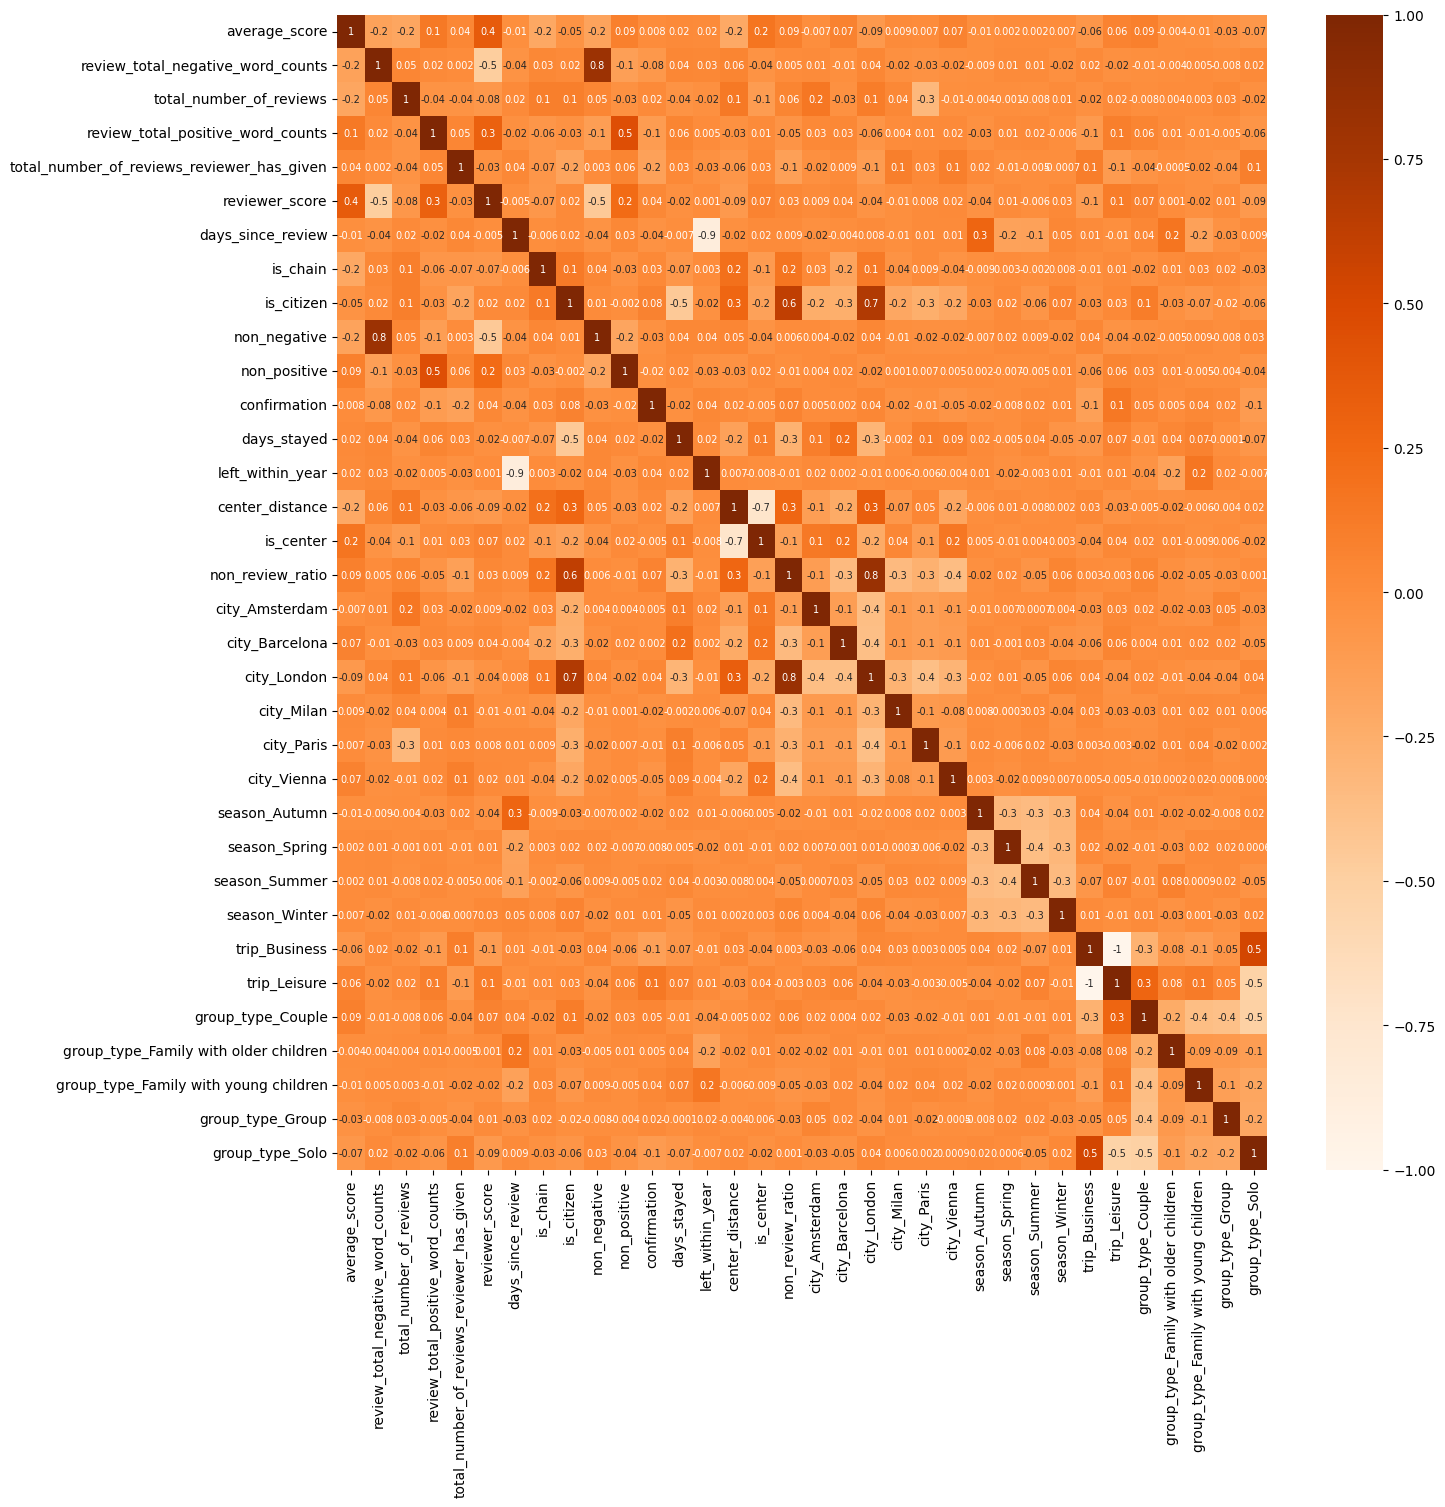

In [284]:
# Поскольку непрерывные признаки распределены не нормально, используем метод Спирмена
corr = data.drop('sample', axis=1).corr(method='spearman')

plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, fmt='.1g', annot_kws={"size":7}, cmap='Oranges')

### Отбор признаков

Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.
Для начала разделим признаки по типу, перечислим их:

In [ ]:
# создадим список, содержащий интересующие числовые признаки
num_features = ['average_score',
                'review_total_negative_word_counts', 'total_number_of_reviews', 
                'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
                'days_since_review', 'center_distance', 'days_stayed', 'non_review_ratio'
               ]

# создадим список, содержащий интересующие категориальные признаки
cat_features = ['is_chain', 'is_citizen', 'non_negative', 'non_positive', 'confirmation',
    'left_within_year', 'is_center', 'city_Amsterdam', 'city_Barcelona',
    'city_London', 'city_Milan', 'city_Paris', 'city_Vienna', 'season_Autumn', 'season_Spring',
    'season_Summer', 'season_Winter', 'trip_Business', 'trip_Leisure', 'group_type_Couple',
    'group_type_Family with older children', 'group_type_Family with young children',
    'group_type_Group', 'group_type_Solo']

<AxesSubplot: >

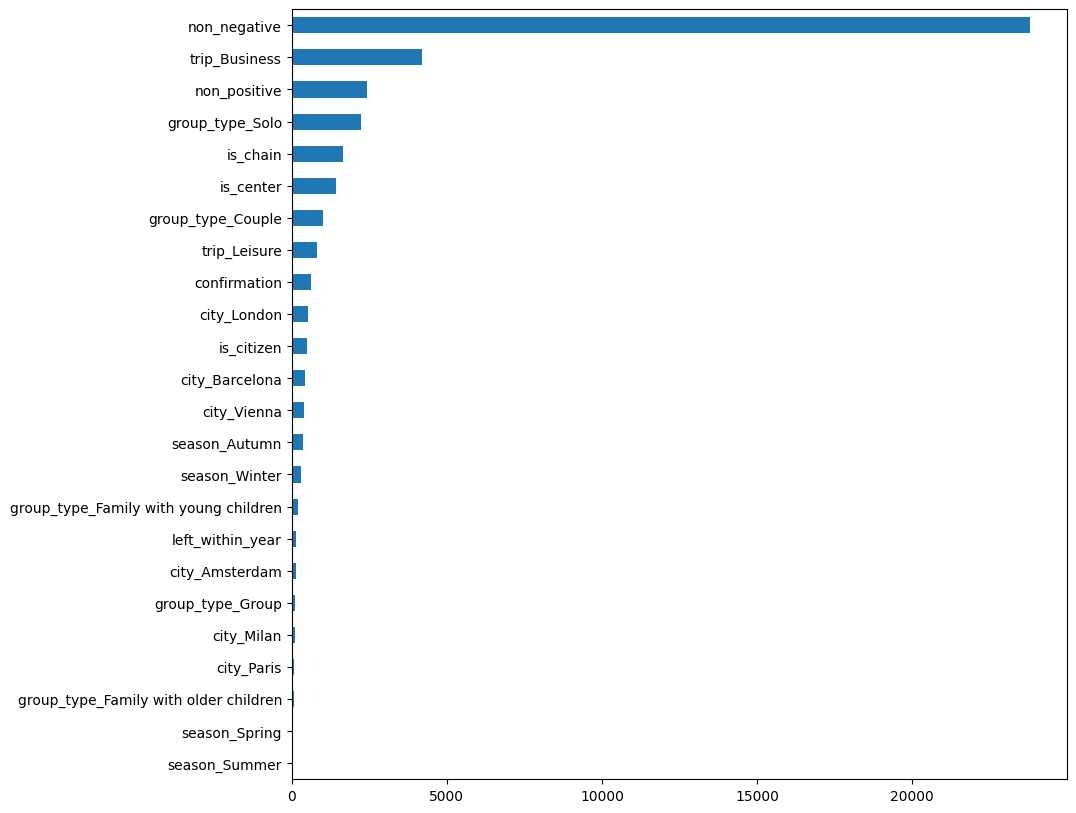

In [295]:
# построим график для отбора категориальных признаков
cat_dep = pd.Series(chi2(iter_1[cat_features], iter_1['reviewer_score'].astype('int'))[0], index=cat_features)
cat_dep.sort_values(inplace = True)
cat_dep.plot(kind = 'barh', figsize=(10, 10))

<AxesSubplot: >

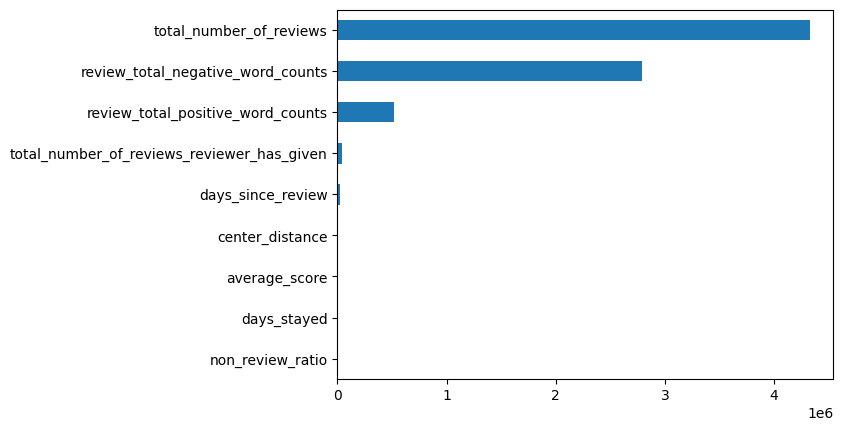

In [296]:
# построим график для отбора непрерывных признаков
num_dep = pd.Series(f_classif(iter_1[num_features], iter_1['reviewer_score'].astype('int'))[0], index=num_features)
num_dep.sort_values(inplace = True)
num_dep.plot(kind = 'barh')

### Построение модели

Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей). Используем специальный инструмент для разбивки train_test_split библиотеки sklearn.model_selection.

In [297]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop('sample', axis=1)
test_data = data.query('sample == 0').drop('sample', axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
# Для тестирования мы будем использовать 25 % от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [ ]:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

In [298]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
    
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
    
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [299]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную 
# процентную ошибку предсказанных значений в отношении фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13518598994791517


In [300]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

NameError: name 'model' is not defined

In [ ]:
test_data = test_data.drop('reviewer_score', axis=1)
predict_submission = regr.predict(test_data)

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)